In [2]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2020-09-29 14:56:45--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat.1’

train_32x32.mat.1   100%[===================>] 173.61M   943KB/s    in 2m 26s  

2020-09-29 14:59:11 (1.19 MB/s) - ‘train_32x32.mat.1’ saved [182040794/182040794]

--2020-09-29 14:59:12--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  3.35MB/s    in 30s     

2020-09-29 14:59:42 (2.06 MB/s) - ‘test_32x32.mat’ saved [6427538

In [6]:
from scipy.io import loadmat
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

Digital Label 9


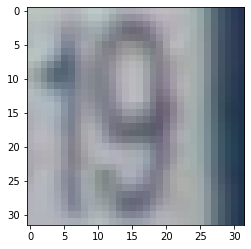

In [14]:
from matplotlib.pyplot import imshow
import numpy as np

X = train['X']
y = train['y']
y[np.where(y == 10)] = 0
example = 0
assert(example < y.shape[0])

print("Digital Label", y[example][0])
imshow(X[:,:,:,example])

In [15]:
# This code downloads the coco dataset from Amazon S3 in parallel.
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess
files = ['val2017.zip', 'annotations_trainval2017.zip', 'train2017.zip']

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

train2017.zip
Finished downloading annotations_trainval2017.zip . Starting to unzip.
Finished unzipping annotations_trainval2017.zip
Finished downloading val2017.zip . Starting to unzip.
Finished unzipping val2017.zip


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [142]:
import os
print(os.chdir('/home/haon/dev/projects'))
print(os.path.exists('data_for_humanpose'))

None
True


In [144]:
import json
import os
os.chdir('/home/haon/dev/projects')
path = 'data_for_humanpose'
with open(path + '/annotations/person_keypoints_val2017.json', 'r') as f:
    meta = json.load(f)

In [145]:
meta.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [146]:
example = 0
img_info = meta['images'][example]
img_annotations = meta['annotations'][example]
img_categories = meta['categories'][0]['keypoints']

In [147]:
print(img_categories)
print('-------------------')
print(img_info.keys())
print('-------------------')
print(img_annotations.keys())

['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']
-------------------
dict_keys(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'])
-------------------
dict_keys(['segmentation', 'num_keypoints', 'area', 'iscrowd', 'keypoints', 'image_id', 'bbox', 'category_id', 'id'])


In [148]:
img_file = str(img_annotations["image_id"])
img_file = img_file.zfill(12) + ".jpg" #img_info['file_name']
print(img_file, img_annotations["image_id"])

000000425226.jpg 425226


In [149]:
def resize_image(img, width=192, height=256):
    img_resized = cv2.resize(img, (width, height))
    return img_resized

def crop_image(img, upper_left_corner, size):
    start_x, start_y = upper_left_corner
    width, height = size
    img_cropped = img[int(start_y):(int(start_y+height)), int(start_x):int(start_x+width), :]
    return img_cropped

def adjust_keypoint(kp, start, scale):
    kp_x, kp_y = kp
    start_x, start_y = start
    sx, sy = scale
    x = (kp_x - start_x) * sx
    y = (kp_y - start_y) * sy
    return x, y

(640, 480, 3) 73.35 206.02 300.58 372.5


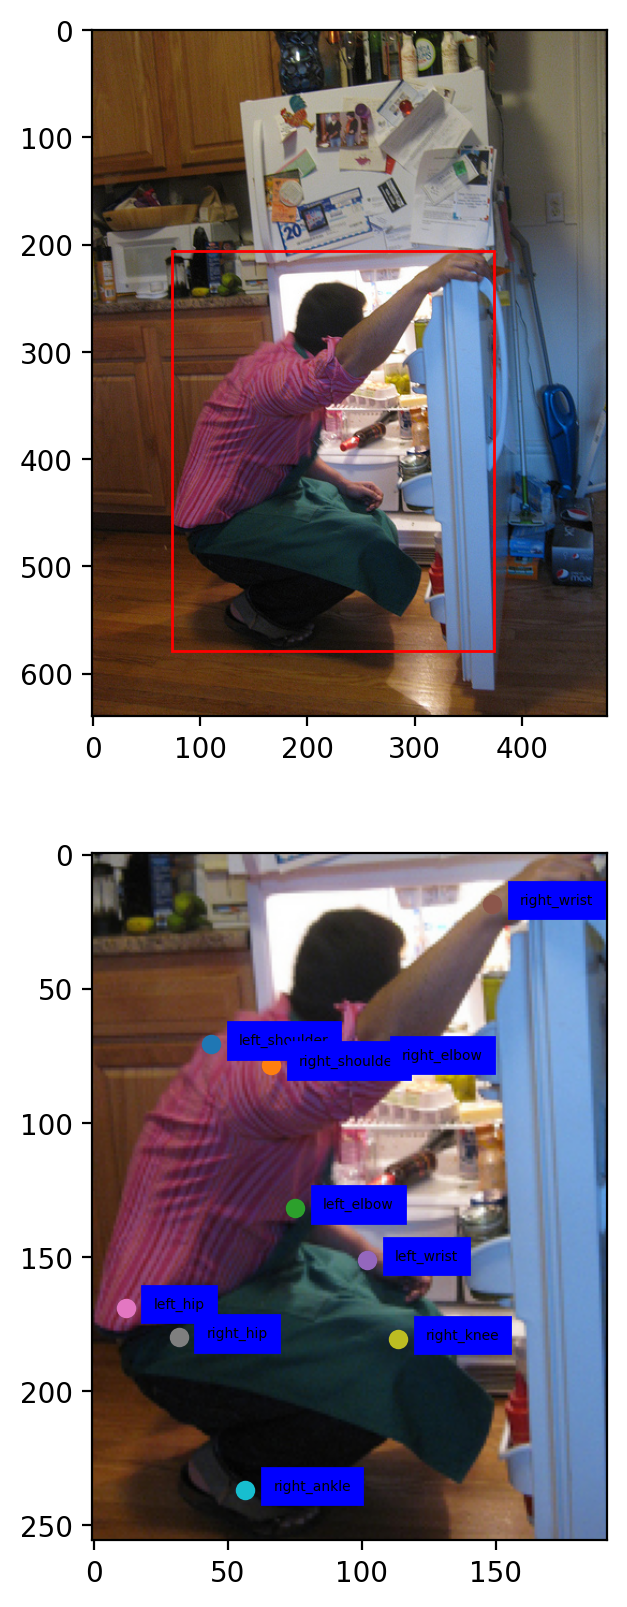

In [151]:
%matplotlib inline
from matplotlib import image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

target_width = 192
target_height = 256

keypoints = img_annotations["keypoints"]

fig, ax = plt.subplots(2, figsize=(20, 10))
fig.set_dpi(200)

img = image.imread(path + "/val2017/" + img_file)
start_x, start_y, width, height = img_annotation["bbox"]
print(img.shape, start_x, start_y, width, height)

r = patches.Rectangle((start_x, start_y), width, height, linewidth=1, edgecolor='r', facecolor='None')

ax[0].imshow(img)
ax[0].add_patch(r)

img_crop = crop_image(img, (start_x, start_y), (width, height))
img_crop = resize_image(img_crop, target_width, target_height)

sx = target_width / width
sy = target_height / height

ax[1].imshow(img_crop)

for i in range(len(keypoints)//3):
    kp = (keypoints[i*3], keypoints[i*3+1])
    visible = keypoints[i*3+2]
    x, y = adjust_keypoint(kp, (start_x, start_y), (sx, sy))
    
    if visible:
        label = img_categories[i]
        ax[1].annotate(label,
                      (x,y),
                      textcoords='offset points',
                      size=5,
                      xytext=(10,0),
                      ha='left',
                      backgroundcolor='b')
        
        ax[1].scatter(x,y)
        
plt.show()